# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [162]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('AZDIAS shape:', azdias.shape)
print('Feature summary shape:', feat_info.shape)

AZDIAS shape: (891221, 85)
Feature summary shape: (85, 4)


In [5]:
# Overview of AZDIAS data
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [8]:
azdias.isna().sum().sum()

4896838

In [9]:
# Overview of feature summary
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [10]:
set(feat_info['missing_or_unknown'])

{'[-1,0,9]',
 '[-1,0]',
 '[-1,9]',
 '[-1,XX]',
 '[-1,X]',
 '[-1]',
 '[0]',
 '[XX]',
 '[]'}

In [11]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [103]:
# Identify missing or unknown data values and convert them to NaNs.
for i in range(azdias.shape[1]):
    feature = feat_info.iloc[i,0]
    nans = feat_info.iloc[i, 3]
    nans = nans.strip('[]')
    nans = nans.split(',')
    for x in nans:
        try:
            azdias[feature].replace(int(x), np.nan, inplace=True)
        except:
            azdias[feature].replace(x, np.nan, inplace=True)

In [13]:
print('Total missing values:', azdias.isnull().sum().sum())

Total missing values: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
for col in azdias.columns:
    print('# of missing values in column', col, azdias[[col]].isna().sum())

# of missing values in column AGER_TYP AGER_TYP    685843
dtype: int64
# of missing values in column ALTERSKATEGORIE_GROB ALTERSKATEGORIE_GROB    2881
dtype: int64
# of missing values in column ANREDE_KZ ANREDE_KZ    0
dtype: int64
# of missing values in column CJT_GESAMTTYP CJT_GESAMTTYP    4854
dtype: int64
# of missing values in column FINANZ_MINIMALIST FINANZ_MINIMALIST    0
dtype: int64
# of missing values in column FINANZ_SPARER FINANZ_SPARER    0
dtype: int64
# of missing values in column FINANZ_VORSORGER FINANZ_VORSORGER    0
dtype: int64
# of missing values in column FINANZ_ANLEGER FINANZ_ANLEGER    0
dtype: int64
# of missing values in column FINANZ_UNAUFFAELLIGER FINANZ_UNAUFFAELLIGER    0
dtype: int64
# of missing values in column FINANZ_HAUSBAUER FINANZ_HAUSBAUER    0
dtype: int64
# of missing values in column FINANZTYP FINANZTYP    0
dtype: int64
# of missing values in column GEBURTSJAHR GEBURTSJAHR    392318
dtype: int64
# of missing values in column GFK_URLAUBERTYP GFK_

In [15]:
print('Columns with no missing values:\n')
for col in azdias.columns[azdias.isna().sum()==0]:
    print(col)

Columns with no missing values:

ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GREEN_AVANTGARDE
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ZABEOTYP


In [16]:
print('Columns with missing values:\n')
for col in azdias.columns[azdias.isna().sum()>0]:
    print(col)

Columns with missing values:

AGER_TYP
ALTERSKATEGORIE_GROB
CJT_GESAMTTYP
GEBURTSJAHR
GFK_URLAUBERTYP
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
KK_KUNDENTYP
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
GEBAEUDETYP
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB


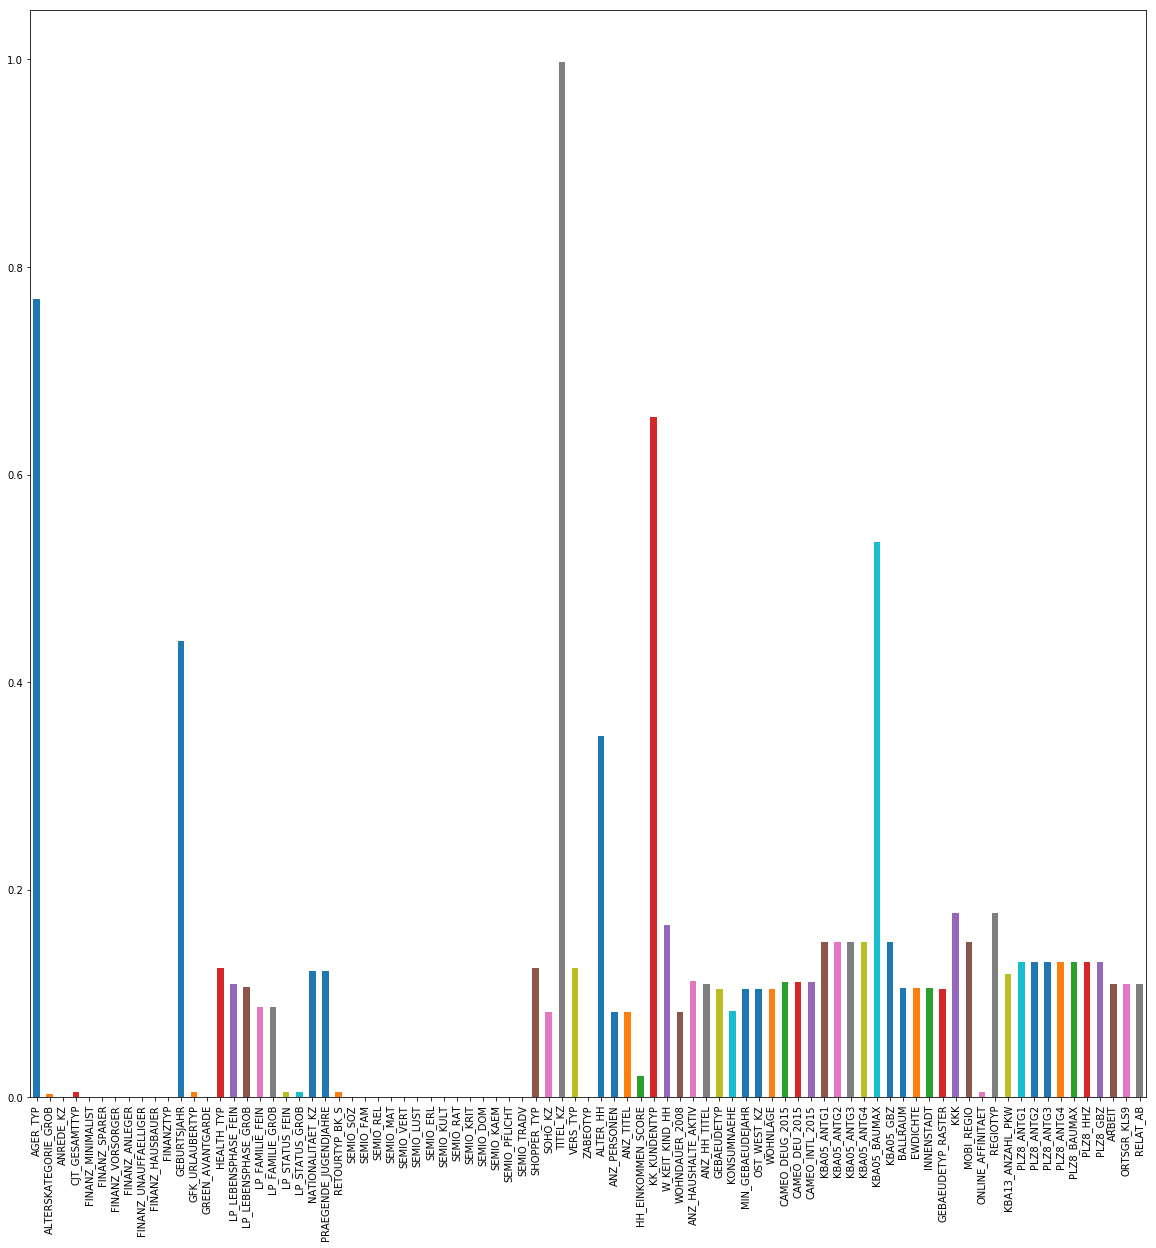

In [17]:
# Investigate patterns in the amount of missing data in each column.
(azdias.isna().sum() / azdias.shape[0]).plot(kind='bar', figsize=(20,20))

In [104]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print('Outlier columns to be dropped:')
outlier_cols = azdias.isna().sum()[(azdias.isna().sum() / azdias.shape[0]) > 0.2].index.tolist()
for col in outlier_cols:
    print(col)

Outlier columns to be dropped:
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


In [108]:
azdias.drop(outlier_cols, axis=1, inplace=True)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

- 24 out of 85 columns with no missing values:

    - ANREDE_KZ
    - FINANZ_MINIMALIST
    - FINANZ_SPARER
    - FINANZ_VORSORGER
    - FINANZ_ANLEGER
    - FINANZ_UNAUFFAELLIGER
    - FINANZ_HAUSBAUER
    - FINANZTYP
    - GREEN_AVANTGARDE
    - SEMIO_SOZ
    - SEMIO_FAM
    - SEMIO_REL
    - SEMIO_MAT
    - SEMIO_VERT
    - SEMIO_LUST
    - SEMIO_ERL
    - SEMIO_KULT
    - SEMIO_RAT
    - SEMIO_KRIT
    - SEMIO_DOM
    - SEMIO_KAEM
    - SEMIO_PFLICHT
    - SEMIO_TRADV
    - ZABEOTYP
    
- 61 out of 85 columns with missing values:

    - AGER_TYP
    - ALTERSKATEGORIE_GROB
    - CJT_GESAMTTYP
    - GEBURTSJAHR
    - GFK_URLAUBERTYP
    - HEALTH_TYP
    - LP_LEBENSPHASE_FEIN
    - LP_LEBENSPHASE_GROB
    - LP_FAMILIE_FEIN
    - LP_FAMILIE_GROB
    - LP_STATUS_FEIN
    - LP_STATUS_GROB
    - NATIONALITAET_KZ
    - PRAEGENDE_JUGENDJAHRE
    - RETOURTYP_BK_S
    - SHOPPER_TYP
    - SOHO_KZ
    - TITEL_KZ
    - VERS_TYP
    - ALTER_HH
    - ANZ_PERSONEN
    - ANZ_TITEL
    - HH_EINKOMMEN_SCORE
    - KK_KUNDENTYP
    - W_KEIT_KIND_HH
    - WOHNDAUER_2008
    - ANZ_HAUSHALTE_AKTIV
    - ANZ_HH_TITEL
    - GEBAEUDETYP
    - KONSUMNAEHE
    - MIN_GEBAEUDEJAHR
    - OST_WEST_KZ
    - WOHNLAGE
    - CAMEO_DEUG_2015
    - CAMEO_DEU_2015
    - CAMEO_INTL_2015
    - KBA05_ANTG1
    - KBA05_ANTG2
    - KBA05_ANTG3
    - KBA05_ANTG4
    - KBA05_BAUMAX
    - KBA05_GBZ
    - BALLRAUM
    - EWDICHTE
    - INNENSTADT
    - GEBAEUDETYP_RASTER
    - KKK
    - MOBI_REGIO
    - ONLINE_AFFINITAET
    - REGIOTYP
    - KBA13_ANZAHL_PKW
    - PLZ8_ANTG1
    - PLZ8_ANTG2
    - PLZ8_ANTG3
    - PLZ8_ANTG4
    - PLZ8_BAUMAX
    - PLZ8_HHZ
    - PLZ8_GBZ
    - ARBEIT
    - ORTSGR_KLS9
    - RELAT_AB
    
- 6 out of 61 columns are to be dropped (more than 20% missing values):

    - AGER_TYP
    - GEBURTSJAHR
    - TITEL_KZ
    - ALTER_HH
    - KK_KUNDENTYP
    - KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [109]:
# How much data is missing in each row of the dataset?
row_nans = pd.DataFrame(azdias.isna().sum(axis=1), columns=['nans'])
row_nans

,nans
0,43
1,0
2,0
3,7
4,0
5,0
6,0
7,0
8,0
9,0


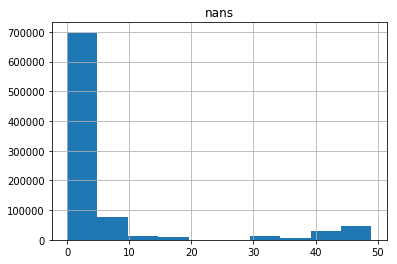

In [110]:
row_nans.hist();

In [111]:
row_nans.describe()

,nans
count,891221.000000
mean,5.649894
std,13.234687
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


In [112]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_few_missing = azdias[row_nans['nans'] < 3].reset_index(drop=True)
azdias_lots_missing = azdias[row_nans['nans'] >= 3].reset_index(drop=True)

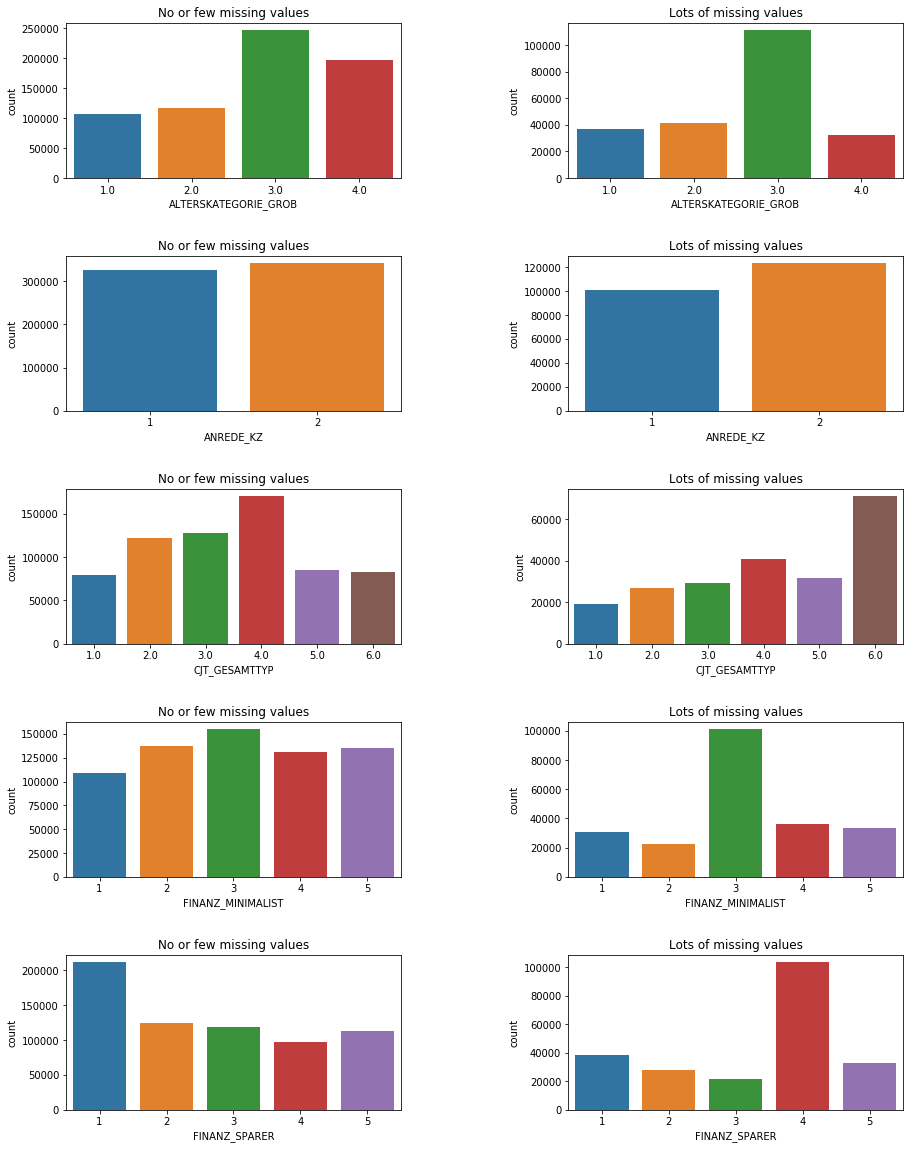

In [113]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols = list(azdias_few_missing)[:5]
fig, axs = plt.subplots(nrows=len(cols), ncols=2, figsize=(15,20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i, col in enumerate(cols):
    sns.countplot(x=col, data=azdias_few_missing, ax=axs[i][0])
    axs[i][0].set_title('No or few missing values')
    sns.countplot(x=col, data=azdias_lots_missing, ax=axs[i][1])
    axs[i][1].set_title('Lots of missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

For feature ANREDE_KZ, the distributions of the dataset with few or no missing values in rows are similar to those of the dataset with lots of missing values. However, for other features, the data with few or no missing values are qualitatively different from the data with lots of missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [114]:
# How many features are there of each data type?
dtype_dict = {}
feat_info_att = feat_info.set_index('attribute')
for col in list(azdias_few_missing):
    dtype = feat_info_att.loc[col, 'type']
    if dtype not in dtype_dict:
        dtype_dict[dtype] = 1
    else:
        dtype_dict[dtype] += 1
        
print('# of features of each data type:', dtype_dict)

# of features of each data type: {'ordinal': 49, 'categorical': 18, 'mixed': 6, 'numeric': 6}


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [115]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
bin_cat_cols = []
multi_cat_cols = []
mixed_cols = []
feat_info_index = feat_info.set_index('attribute')
for col in list(azdias_few_missing):
    if feat_info_index.loc[col, 'type'] == 'categorical':
        if len(azdias_few_missing[col].unique()) == 2:
            bin_cat_cols.append(col)
        else:
            multi_cat_cols.append(col)
    elif feat_info_index.loc[col, 'type'] == 'mixed':
        if col in list(azdias_few_missing):
            mixed_cols.append(col)
            
print('Binary categorical variables:')
for col in bin_cat_cols:
    print(col)

print('\nMulti-level categorical variables:')
for col in multi_cat_cols:
    print(col)
    
print('\nMixed type variables:')
for col in mixed_cols:
    print(col)

Binary categorical variables:
ANREDE_KZ
GREEN_AVANTGARDE
SOHO_KZ
VERS_TYP
OST_WEST_KZ

Multi-level categorical variables:
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
ZABEOTYP
GEBAEUDETYP
CAMEO_DEUG_2015
CAMEO_DEU_2015

Mixed type variables:
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
PLZ8_BAUMAX


In [116]:
for col in bin_cat_cols:
    print(azdias_few_missing[col].value_counts(), '\n')

2    342016
1    324857
Name: ANREDE_KZ, dtype: int64 

0    513554
1    153319
Name: GREEN_AVANTGARDE, dtype: int64 

0.0    661245
1.0      5628
Name: SOHO_KZ, dtype: int64 

2.0    353287
1.0    313586
Name: VERS_TYP, dtype: int64 

W    522103
O    144770
Name: OST_WEST_KZ, dtype: int64 



In [117]:
for col in multi_cat_cols:
    print(azdias_few_missing[col].value_counts(), '\n')

4.0    170143
3.0    127276
2.0    121626
5.0     85374
6.0     82620
1.0     79834
Name: CJT_GESAMTTYP, dtype: int64 

6    257042
1    155385
5     92399
2     87421
4     47251
3     27375
Name: FINANZTYP, dtype: int64 

12.0    103927
10.0     87245
8.0      73136
11.0     63597
5.0      61670
4.0      54417
3.0      46431
9.0      46236
1.0      43016
7.0      34485
2.0      30347
6.0      22366
Name: GFK_URLAUBERTYP, dtype: int64 

1.0     346872
10.0    116379
2.0      85562
11.0     44379
8.0      18482
7.0      15574
4.0       9970
5.0       9752
9.0       9378
6.0       6636
3.0       3889
Name: LP_FAMILIE_FEIN, dtype: int64 

1.0    346872
5.0    170136
2.0     85562
4.0     40692
3.0     23611
Name: LP_FAMILIE_GROB, dtype: int64 

1.0     184285
9.0     108774
10.0     98341
2.0      85564
4.0      63448
3.0      61018
6.0      25071
5.0      20894
8.0      11416
7.0       8062
Name: LP_STATUS_FEIN, dtype: int64 

1.0    269849
2.0    145360
4.0    120190
5.0     98341
3.0 

In [118]:
# Drop multi-categorical columns
azdias_few_missing.drop(multi_cat_cols, axis=1, inplace=True)

In [119]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_few_missing = pd.get_dummies(azdias_few_missing, columns=bin_cat_cols)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- Binary categorical variables are re-encoded with one-hot:
    - SOHO_KZ
    - OST_WEST_KZ
    - VERS_TYP
    - ANREDE_KZ
    - GREEN_AVANTGARDE

- Multi-categorical variables are dropped:
    - CAMEO_DEU_2015
    - LP_FAMILIE_GROB
    - GFK_URLAUBERTYP
    - CJT_GESAMTTYP
    - CAMEO_DEUG_2015
    - GEBAEUDETYP
    - LP_STATUS_GROB
    - SHOPPER_TYP
    - FINANZTYP
    - ZABEOTYP
    - LP_FAMILIE_FEIN
    - NATIONALITAET_KZ
    - LP_STATUS_FEIN

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [120]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def map_decade(x):
    if x <= 2:
        return 1
    elif x <= 4:
        return 2
    elif x <= 7:
        return 3
    elif x <= 9:
        return 4
    elif x <= 13:
        return 5
    elif x <= 15:
        return 6
    else: # take care of NaN
        pass
    
def map_movement(x):
    if x in [2, 4, 6, 7, 9, 11, 13, 15]:
        return 0
    elif x in [1, 3, 5, 8, 10, 12, 14]:
        return 1

azdias_few_missing['DECADE'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
azdias_few_missing['MOVEMENT'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

In [121]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def map_wealth(x):
    try: # take care of NaN
        x = int(x)
        if x // 10 == 1:
            return 1
        elif x // 10 == 2:
            return 2
        elif x // 10 == 3:
            return 3
        elif x // 10 == 5:
            return 5
    except:
        pass
    
def map_life_state(x):
    try:
        x = int(x)
        if x % 10 == 1:
            return 1
        elif x % 10 == 2:
            return 2
        elif x % 10 == 3:
            return 3
        elif x % 10 == 4:
            return 4
        elif x % 10 == 5:
            return 5
    except:
        pass

azdias_few_missing['WEALTH'] = azdias_few_missing['CAMEO_INTL_2015'].apply(map_wealth)
azdias_few_missing['LIFE_STAGE'] = azdias_few_missing['CAMEO_INTL_2015'].apply(map_life_state)

In [122]:
# Drop mixed type columns
azdias_few_missing.drop(mixed_cols, axis=1, inplace=True)

In [123]:
# Re-encode categorical variable
azdias_few_missing = pd.get_dummies(azdias_few_missing, columns=['MOVEMENT'])

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- For feature PRAEGENDE_JUGENDJAHRE, an interval-type varialbe DECADE is created to capture generations from 40s to 90s and a binary variable MOVEMENT is created to encode categories of mainstream and avantgarde.

- For feature CAMEO_INTL_2015, two ordinal variables, WEALTH and LIFE_STAGE, are created to encode wealth and life stage information, respectively.

- Features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 are dropped since their information has been reformulated into other two variables. Other mixed-type features such as LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE, KBA05_BAUMAX and PLZ8_BAUMAX, are also dropped since their information are captured in other variables.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [166]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(df.shape[1]):
        feature = feat_info.iloc[i,0]
        nans = feat_info.iloc[i, 3]
        nans = nans.strip('[]')
        nans = nans.split(',')
        for x in nans:
            try:
                df[feature].replace(int(x), np.nan, inplace=True)
            except:
                df[feature].replace(x, np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    outlier_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(outlier_cols, axis=1, inplace=True)
    df_few_missing = df[azdias.isna().sum(axis=1) < 3].reset_index(drop=True)

    
    # select, re-encode, and engineer column values.
    multi_cat_cols = ['CJT_GESAMTTYP',
                      'FINANZTYP',
                      'GFK_URLAUBERTYP',
                      'LP_FAMILIE_FEIN',
                      'LP_FAMILIE_GROB',
                      'LP_STATUS_FEIN',
                      'LP_STATUS_GROB',
                      'NATIONALITAET_KZ',
                      'SHOPPER_TYP',
                      'ZABEOTYP',
                      'GEBAEUDETYP',
                      'CAMEO_DEUG_2015',
                      'CAMEO_DEU_2015']
    
    bin_cat_cols = ['ANREDE_KZ',
                    'GREEN_AVANTGARDE',
                    'SOHO_KZ',
                    'VERS_TYP',
                    'OST_WEST_KZ']
    
    mixed_cols = ['LP_LEBENSPHASE_FEIN',
                    'LP_LEBENSPHASE_GROB',
                    'PRAEGENDE_JUGENDJAHRE',
                    'WOHNLAGE',
                    'CAMEO_INTL_2015',
                    'PLZ8_BAUMAX']
    
    df_few_missing.drop(multi_cat_cols, axis=1, inplace=True)
    df_few_missing = pd.get_dummies(df_few_missing, columns=bin_cat_cols)
    
    df_few_missing['DECADE'] = df_few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
    df_few_missing['MOVEMENT'] = df_few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

    df_few_missing['WEALTH'] = df_few_missing['CAMEO_INTL_2015'].apply(map_wealth)
    df_few_missing['LIFE_STAGE'] = df_few_missing['CAMEO_INTL_2015'].apply(map_life_state)

    df_few_missing.drop(mixed_cols, axis=1, inplace=True)
    df_few_missing = pd.get_dummies(df_few_missing, columns=['MOVEMENT'])

    # Return the cleaned dataframe.
    return df_few_missing

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [128]:
# Cleaned the dataset of all NaN values
imp = Imputer(missing_values=np.nan, strategy='most_frequent')
azdias_few_missing.iloc[:,:] = imp.fit_transform(azdias_few_missing)

In [129]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_few_missing.iloc[:,:] = scaler.fit_transform(azdias_few_missing)

### Discussion 2.1: Apply Feature Scaling

Missing values are imputed with the most frequent value(s) in each variable. Every feature is stadardized to mean 0 and stadard deviation 1 so that each of them are equally contributed to the algorithm.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [132]:
# Apply PCA to the data.
pca = PCA(random_state=0)
azdias_few_missing_pca = pca.fit_transform(azdias_few_missing)

In [133]:
# Investigate the variance accounted for by each principal component.
# This function is defined by Udacity
def scree_plot(pca, annotate=False, figsize=(15,10)):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    if annotate:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), 
                        (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    plt.grid(axis='y')
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component", fontsize=15)
    ax.set_ylabel("Variance Explained (%)", fontsize=15)
    plt.title('Explained Variance Per Principal Component', fontsize=20)

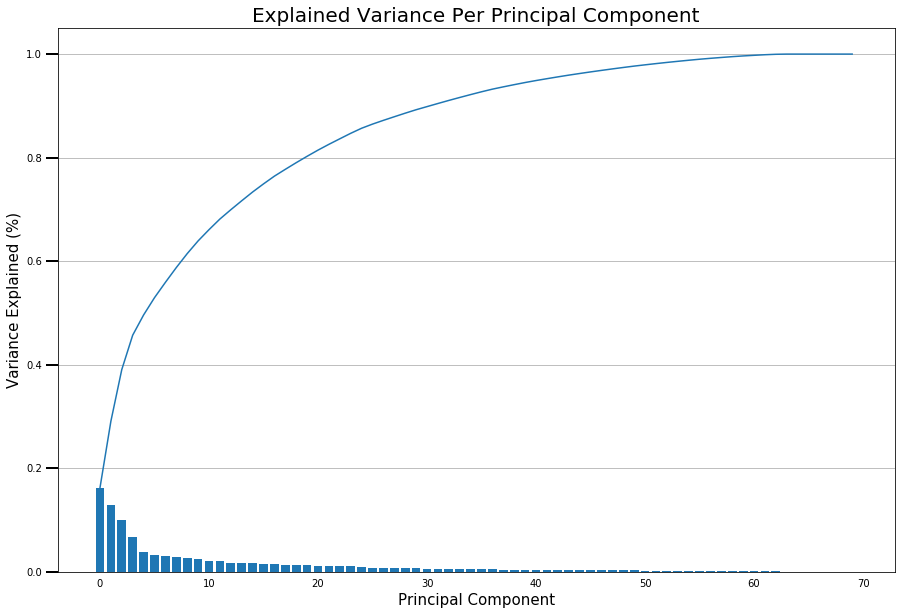

In [134]:
scree_plot(pca)

In [135]:
for i in range(1, len(pca.explained_variance_ratio_)+1):
    print('First {} component(s) explained {}% of variance in the original data.'.
        format(i, np.sum(pca.explained_variance_ratio_[:i]))) 

First 1 component(s) explained 0.162263251521025% of variance in the original data.
First 2 component(s) explained 0.2908391544409761% of variance in the original data.
First 3 component(s) explained 0.3906401146042395% of variance in the original data.
First 4 component(s) explained 0.45699949336455686% of variance in the original data.
First 5 component(s) explained 0.4960560896680457% of variance in the original data.
First 6 component(s) explained 0.5294515808220926% of variance in the original data.
First 7 component(s) explained 0.5590555182459662% of variance in the original data.
First 8 component(s) explained 0.5876372117026485% of variance in the original data.
First 9 component(s) explained 0.6145309232508934% of variance in the original data.
First 10 component(s) explained 0.639120195861225% of variance in the original data.
First 11 component(s) explained 0.6608175171813315% of variance in the original data.
First 12 component(s) explained 0.6813843973024203% of variance 

In [137]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_32 = PCA(32, random_state=0)
azdias_few_missing_pca = pca_32.fit_transform(azdias_few_missing)

### Discussion 2.2: Perform Dimensionality Reduction

- The first 5 components explained 49% of the variability explained in the original data
- The first 20 componennts explained 81% of the variability explained in the original data
- The first 32 componennts explained 90% of the variability explained in the original data
- To retain 90% of the variability explained in the original data, 32 componenets are chosen for later analysis

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [138]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# This function is modified based on the function defined by Udacity
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


def pca_weights(result, dimention):
    '''
    Returns the sorted feature weights in decending order for each principal component.
    '''
    return result.loc[dimention, 'ALTERSKATEGORIE_GROB':].sort_values(ascending=False)


def plot_pca(result, dimension, figsize=(20,15)):
    '''
    Plot feature weight in descending order for a principal component.
    '''
    dim = result.loc[dimension, 'ALTERSKATEGORIE_GROB':].sort_values(ascending=False)
    pos_dim = dim[dim>=0]
    neg_dim = dim[dim<=0]
    title = dimension + ': ' + str(result.loc[dimension, 'Explained Variance']) + ' Variance Explained'
    
    # Create a bar plot visualization
    plt.figure(figsize = figsize)
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(title, fontsize=20)
    plt.subplot(211)
    pos_dim.plot(kind = 'bar');
    plt.ylabel("Feature Weights")
    plt.grid(axis='y')
    plt.subplot(212)
    neg_dim.plot(kind = 'bar');
    plt.ylabel("Feature Weights")
    plt.grid(axis='y')

In [139]:
results = pca_results(azdias_few_missing, pca_32)
results.head()

,Explained Variance,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,WEALTH,LIFE_STAGE,MOVEMENT_0.0,MOVEMENT_1.0
Dimension 1,0.1623,-0.1254,-0.2189,0.1464,-0.1177,0.0759,0.0735,0.1575,0.0320,-0.0270,...,-0.0022,-0.0229,0.0229,0.0663,-0.0663,0.1069,0.1938,-0.1232,-0.1383,0.1346
Dimension 2,0.1286,0.2445,0.0435,-0.2189,0.2124,-0.1791,-0.2130,0.1234,-0.0540,0.1494,...,-0.0026,-0.0302,0.0302,0.0321,-0.0321,-0.2250,0.0704,-0.0014,-0.0304,0.0210
Dimension 3,0.0998,0.1112,0.1479,-0.1210,0.1178,-0.2028,-0.1132,-0.0241,-0.0122,0.1297,...,-0.0001,-0.0336,0.0336,0.0163,-0.0163,-0.1258,0.0365,-0.0117,0.0553,-0.0576
Dimension 4,0.0664,-0.0532,-0.0006,0.0294,-0.0342,-0.0741,0.0934,-0.0488,-0.0020,-0.0088,...,0.0011,-0.0171,0.0171,-0.0938,0.0938,0.0530,-0.0562,0.0208,0.3670,-0.3612
Dimension 5,0.0391,0.0067,0.0538,-0.0094,-0.0998,0.0814,-0.0950,0.0083,-0.0555,-0.0458,...,0.0023,0.1132,-0.1132,0.4370,-0.4370,0.0065,-0.0228,0.0644,0.0760,-0.0728


In [140]:
pca_weights(results, 'Dimension 1')

PLZ8_ANTG3               0.2130
HH_EINKOMMEN_SCORE       0.2083
PLZ8_ANTG4               0.2073
WEALTH                   0.1938
ORTSGR_KLS9              0.1779
EWDICHTE                 0.1749
FINANZ_HAUSBAUER         0.1575
KBA05_ANTG4              0.1486
FINANZ_SPARER            0.1464
PLZ8_ANTG2               0.1406
GREEN_AVANTGARDE_0       0.1383
ARBEIT                   0.1376
KBA05_ANTG3              0.1353
MOVEMENT_1.0             0.1346
ANZ_HAUSHALTE_AKTIV      0.1328
RELAT_AB                 0.1233
SEMIO_PFLICHT            0.1143
SEMIO_REL                0.1096
DECADE                   0.1069
SEMIO_TRADV              0.0977
SEMIO_RAT                0.0968
SEMIO_MAT                0.0822
SEMIO_FAM                0.0765
FINANZ_ANLEGER           0.0759
FINANZ_UNAUFFAELLIGER    0.0735
SEMIO_KULT               0.0729
REGIOTYP                 0.0699
OST_WEST_KZ_O            0.0663
KKK                      0.0510
SEMIO_SOZ                0.0409
                          ...  
SOHO_KZ_

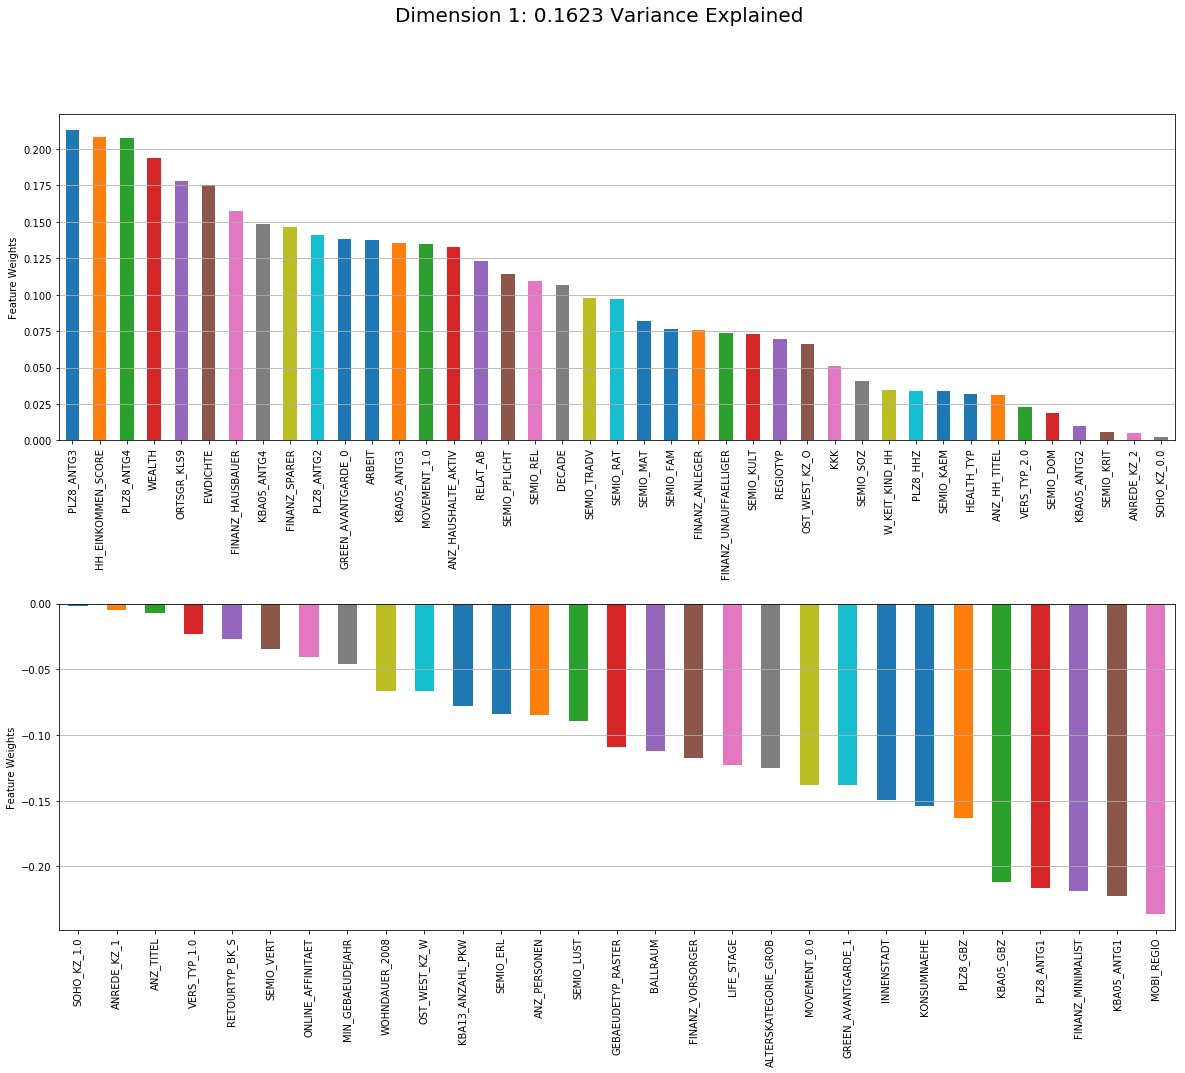

In [141]:
plot_pca(results, 'Dimension 1')

In [142]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(results, 'Dimension 2')

SEMIO_ERL                0.2461
ALTERSKATEGORIE_GROB     0.2445
FINANZ_VORSORGER         0.2124
SEMIO_LUST               0.1700
RETOURTYP_BK_S           0.1494
SEMIO_KRIT               0.1471
SEMIO_KAEM               0.1451
ANREDE_KZ_2              0.1282
FINANZ_HAUSBAUER         0.1234
W_KEIT_KIND_HH           0.1070
SEMIO_DOM                0.0978
PLZ8_ANTG3               0.0897
PLZ8_ANTG4               0.0858
EWDICHTE                 0.0836
ORTSGR_KLS9              0.0830
WEALTH                   0.0704
KBA05_ANTG4              0.0682
ARBEIT                   0.0649
RELAT_AB                 0.0598
ANZ_HAUSHALTE_AKTIV      0.0596
PLZ8_ANTG2               0.0593
HH_EINKOMMEN_SCORE       0.0588
WOHNDAUER_2008           0.0531
KBA05_ANTG3              0.0471
FINANZ_MINIMALIST        0.0435
OST_WEST_KZ_O            0.0321
GREEN_AVANTGARDE_0       0.0304
VERS_TYP_2.0             0.0302
ANZ_HH_TITEL             0.0286
MOVEMENT_1.0             0.0210
                          ...  
GREEN_AV

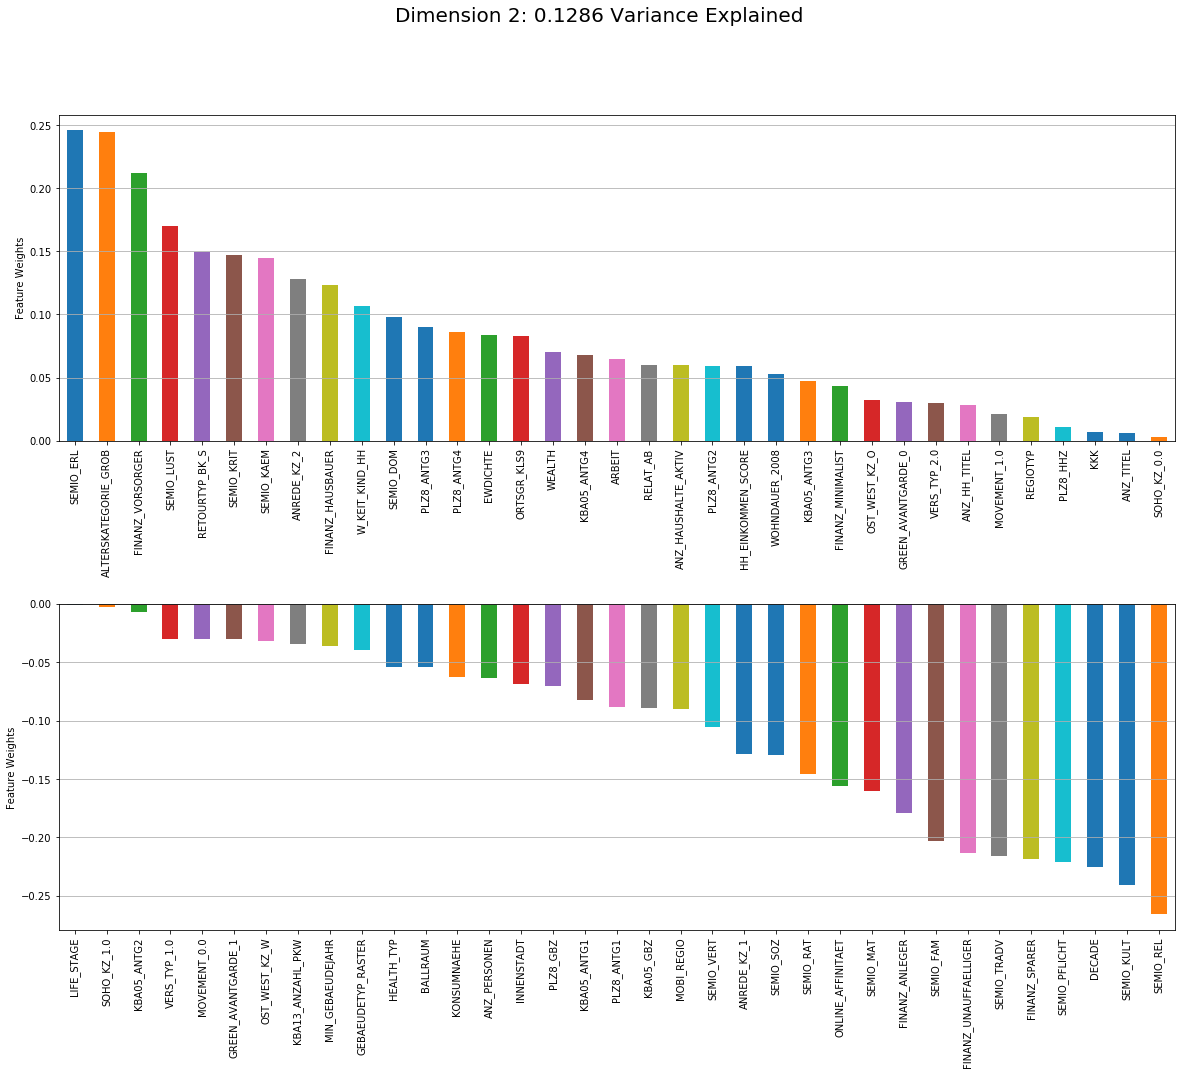

In [143]:
plot_pca(results, 'Dimension 2')

In [144]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(results, 'Dimension 3')

ANREDE_KZ_1              0.3318
SEMIO_VERT               0.3114
SEMIO_SOZ                0.2291
SEMIO_FAM                0.2080
SEMIO_KULT               0.1854
FINANZ_MINIMALIST        0.1479
RETOURTYP_BK_S           0.1297
FINANZ_VORSORGER         0.1178
ALTERSKATEGORIE_GROB     0.1112
W_KEIT_KIND_HH           0.1006
SEMIO_LUST               0.0914
EWDICHTE                 0.0709
ORTSGR_KLS9              0.0709
PLZ8_ANTG3               0.0656
PLZ8_ANTG4               0.0647
GREEN_AVANTGARDE_1       0.0553
MOVEMENT_0.0             0.0553
ARBEIT                   0.0474
RELAT_AB                 0.0453
PLZ8_ANTG2               0.0446
KBA05_ANTG4              0.0410
WOHNDAUER_2008           0.0373
ANZ_HAUSHALTE_AKTIV      0.0371
WEALTH                   0.0365
SEMIO_REL                0.0363
VERS_TYP_2.0             0.0336
SEMIO_MAT                0.0254
ANZ_HH_TITEL             0.0195
KBA05_ANTG3              0.0173
OST_WEST_KZ_O            0.0163
                          ...  
ANZ_PERS

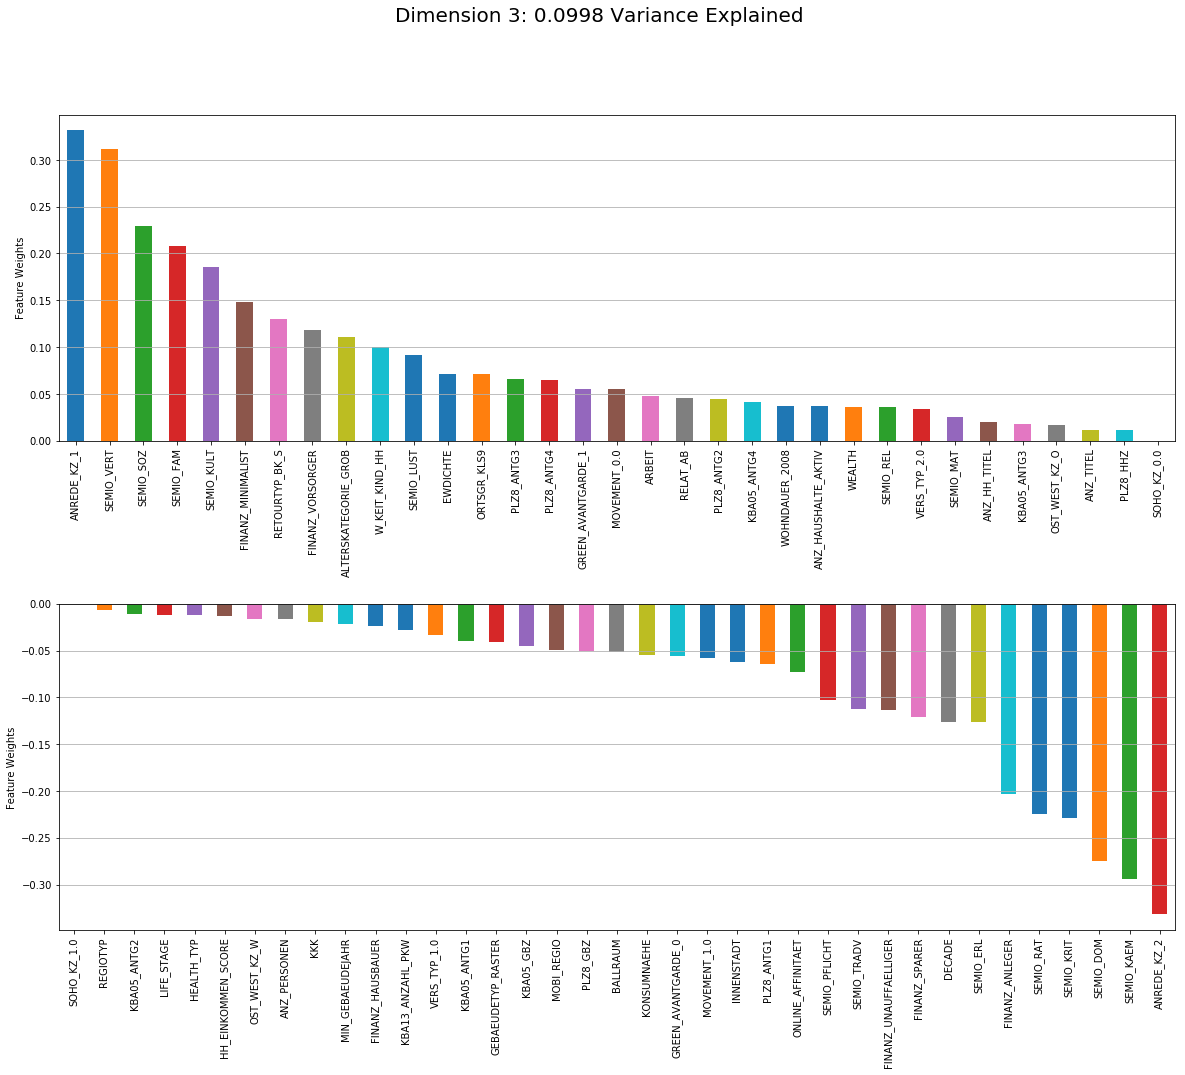

In [145]:
plot_pca(results, 'Dimension 3')

### Discussion 2.3: Interpret Principal Components

- Principal component 1:
    - Highest positive features:
        - PLZ8_ANTG3               Number of 6-10 family houses in the PLZ8 region                    
        - HH_EINKOMMEN_SCORE       Estimated household net income
        - PLZ8_ANTG4               Number of 10+ family houses in the PLZ8 region  
        - WEALTH                   Wealth status  
        - ORTSGR_KLS9              Size of community
    - Lowest negative features:
        - FINANZ_MINIMALIST        Financial typology
        - KBA05_ANTG1              Number of 1-2 family houses in the microcell
        - MOBI_REGIO               Movement patterns

- Principal component 2:
    - Highest positive features:
        - SEMIO_ERL                Personality typology     
        - ALTERSKATEGORIE_GROB     Estimated age based on given name analysis                 
        - FINANZ_VORSORGER         Financial typology
        - SEMIO_LUST               Personality typology  
        - RETOURTYP_BK_S           Shopper return type
    - Lowest negative features:
        - DECADE                   Dominating movement of person's youth
        - SEMIO_KULT               Personality typology
        - SEMIO_REL                Personality typology

- Principal component 3:
    - Highest positive features:
        - ANREDE_KZ_1              Gender
        - SEMIO_VERT               Personality typology                      
        - SEMIO_SOZ                Personality typology 
        - SEMIO_FAM                Personality typology  
        - SEMIO_KULT               Personality typology
    - Lowest negative features:
        - SEMIO_DOM                Personality typology
        - SEMIO_KAEM               Personality typology
        - ANREDE_KZ_2              Gender
       
- Based on the above postive and netagative values of features, community size, household income, weath status, age, customer royalty, finacial typology play import roles in postive values. Yet, movement pattens plays dominant the negative values. Furthermore, family size, community location, peresonality typology, gender play dual role in both postive and negative values.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [146]:
# Over a number of different cluster counts...
inertias = []
for k in range(2, 16):
    kmeans = KMeans(k, random_state=0)
    
    # run k-means clustering on the data and...
    kmeans = kmeans.fit(azdias_few_missing_pca)
    
    # compute the average within-cluster distances.
    inertias.append(kmeans.inertia_)

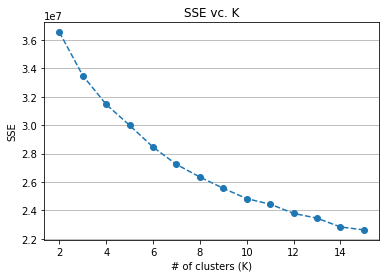

In [147]:
# Investigate the change in within-cluster distance across number of clusters.
plt.plot(range(2,16), inertias, linestyle='--', marker='o')
plt.xlabel('# of clusters (K)')
plt.ylabel('SSE')
plt.title('SSE vc. K')
plt.grid(axis='y')
plt.show();

In [148]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(13, random_state=0)
keamns = kmeans.fit(azdias_few_missing_pca)
preds_gen = kmeans.predict(azdias_few_missing_pca)

### Discussion 3.1: Apply Clustering to General Population

There is no obvious elbow in the above graph. Yet, the slop starts to decrease little after 13, so 13 clusters are a reasonable threshold.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [167]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [168]:
c = customers.copy(deep=True)

In [169]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_df = clean_data(c)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [171]:
customers_df.iloc[:,:] = imp.transform(customers_df)
customers_df.iloc[:,:] = scaler.transform(customers_df)
customers_df_pca = pca_32.transform(customers_df)
preds_cus = kmeans.predict(customers_df_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

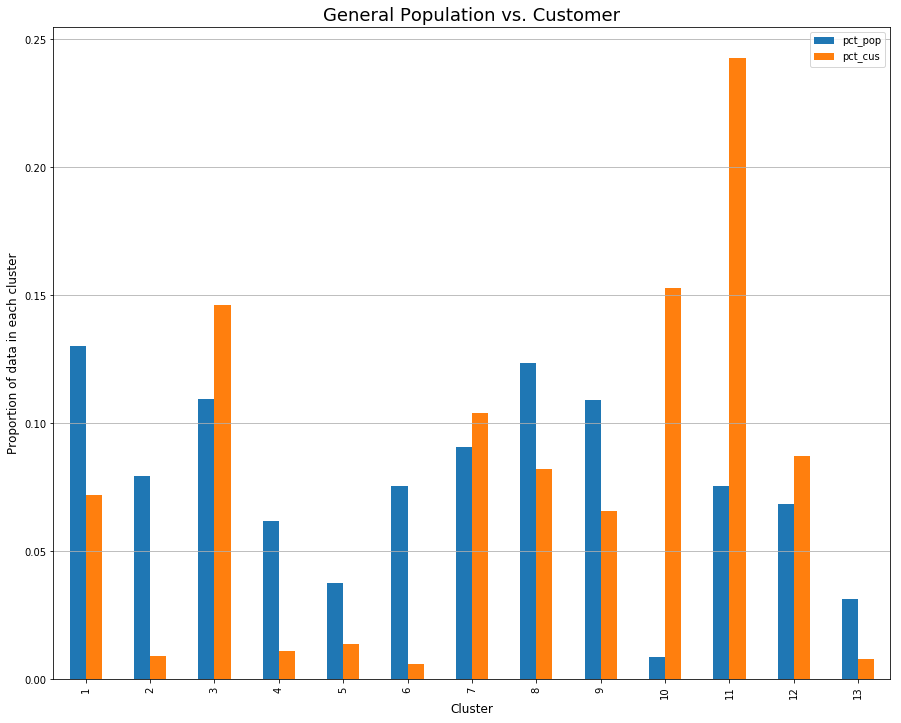

In [179]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

pct_pop = []
pct_cus = []
for i in range(13):
    pct_pop.append(np.mean(preds_gen == i))
    pct_cus.append(np.mean(preds_cus == i))

C = [c+1 for c in range(13)]
pct_df = pd.DataFrame({'C': C, 'pct_pop': pct_pop, 'pct_cus': pct_cus})

pct_df.plot(x='C', y=['pct_pop', 'pct_cus'], kind='bar', figsize=(15,12))
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Proportion of data in each cluster', fontsize=12)
plt.title('General Population vs. Customer', fontsize=18)
plt.grid(axis='y')
plt.show();

In [184]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
o9 = np.round(scaler.inverse_transform(pca_32.inverse_transform(customers_df_pca[preds_cus==9])))
df_9 = pd.DataFrame(data=o9, columns=customers_df.columns)
df_9.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,WEALTH,LIFE_STAGE,MOVEMENT_0.0,MOVEMENT_1.0
0,2.0,2.0,4.0,2.0,4.0,4.0,3.0,3.0,3.0,2.0,...,0.0,0.0,1.0,0.0,1.0,6.0,5.0,1.0,0.0,1.0
1,2.0,3.0,4.0,2.0,4.0,4.0,3.0,3.0,3.0,3.0,...,1.0,0.0,1.0,0.0,1.0,6.0,5.0,1.0,0.0,1.0
2,2.0,3.0,4.0,2.0,4.0,4.0,3.0,3.0,3.0,2.0,...,1.0,0.0,1.0,0.0,1.0,6.0,5.0,1.0,0.0,1.0
3,2.0,2.0,4.0,2.0,4.0,4.0,3.0,3.0,3.0,2.0,...,0.0,0.0,1.0,0.0,1.0,6.0,5.0,1.0,0.0,1.0
4,2.0,3.0,4.0,2.0,4.0,4.0,3.0,3.0,3.0,3.0,...,1.0,0.0,1.0,0.0,1.0,6.0,5.0,1.0,0.0,1.0


In [185]:
o10 = np.round(scaler.inverse_transform(pca_32.inverse_transform(customers_df_pca[preds_cus==10])))
df_10 = pd.DataFrame(data=o10, columns=customers_df.columns)
df_10.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,WEALTH,LIFE_STAGE,MOVEMENT_0.0,MOVEMENT_1.0
0,3.0,5.0,1.0,5.0,1.0,2.0,2.0,3.0,3.0,7.0,...,0.0,-0.0,1.0,-0.0,1.0,3.0,2.0,4.0,1.0,-0.0
1,3.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,5.0,4.0,...,0.0,1.0,0.0,0.0,1.0,3.0,2.0,3.0,1.0,0.0
2,4.0,5.0,1.0,5.0,0.0,2.0,2.0,1.0,5.0,6.0,...,-0.0,1.0,-0.0,0.0,1.0,3.0,1.0,5.0,1.0,-0.0
3,3.0,5.0,2.0,4.0,2.0,3.0,1.0,3.0,2.0,6.0,...,0.0,-0.0,1.0,-0.0,1.0,4.0,1.0,5.0,1.0,0.0
4,4.0,5.0,1.0,4.0,1.0,2.0,2.0,1.0,5.0,6.0,...,0.0,1.0,-0.0,0.0,1.0,3.0,1.0,5.0,1.0,-0.0


In [207]:
pca1 = ['PLZ8_ANTG3', 'HH_EINKOMMEN_SCORE', 'PLZ8_ANTG4', 'WEALTH', 'ORTSGR_KLS9', 'LIFE_STAGE', 
            'KBA05_GBZ', 'PLZ8_ANTG1', 'FINANZ_MINIMALIST', 'KBA05_ANTG1', 'MOBI_REGIO']
df_9[pca1].head()

,PLZ8_ANTG3,HH_EINKOMMEN_SCORE,PLZ8_ANTG4,WEALTH,ORTSGR_KLS9,LIFE_STAGE,KBA05_GBZ,PLZ8_ANTG1,FINANZ_MINIMALIST,KBA05_ANTG1,MOBI_REGIO
0,2.0,4.0,1.0,5.0,5.0,1.0,3.0,2.0,2.0,1.0,3.0
1,2.0,4.0,1.0,5.0,5.0,1.0,3.0,2.0,3.0,1.0,3.0
2,2.0,5.0,1.0,5.0,5.0,1.0,3.0,2.0,3.0,1.0,3.0
3,2.0,4.0,1.0,5.0,5.0,1.0,3.0,2.0,2.0,1.0,3.0
4,2.0,4.0,1.0,5.0,5.0,1.0,3.0,2.0,3.0,1.0,3.0


In [208]:
df_10[pca1].head()

,PLZ8_ANTG3,HH_EINKOMMEN_SCORE,PLZ8_ANTG4,WEALTH,ORTSGR_KLS9,LIFE_STAGE,KBA05_GBZ,PLZ8_ANTG1,FINANZ_MINIMALIST,KBA05_ANTG1,MOBI_REGIO
0,2.0,2.0,1.0,2.0,5.0,4.0,3.0,2.0,5.0,2.0,3.0
1,1.0,1.0,0.0,2.0,3.0,3.0,4.0,3.0,5.0,3.0,5.0
2,1.0,2.0,1.0,1.0,4.0,5.0,4.0,3.0,5.0,3.0,4.0
3,1.0,1.0,0.0,1.0,7.0,5.0,4.0,3.0,5.0,2.0,4.0
4,-0.0,2.0,-0.0,1.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0


In [186]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
o1 = np.round(scaler.inverse_transform(pca_32.inverse_transform(customers_df_pca[preds_cus==1])))
df_1 = pd.DataFrame(data=o1, columns=customers_df.columns)
df_1.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,WEALTH,LIFE_STAGE,MOVEMENT_0.0,MOVEMENT_1.0
0,2.0,3.0,4.0,2.0,4.0,5.0,2.0,3.0,5.0,2.0,...,-0.0,1.0,0.0,0.0,1.0,6.0,2.0,4.0,0.0,1.0
1,1.0,3.0,4.0,2.0,5.0,4.0,1.0,3.0,2.0,2.0,...,0.0,0.0,1.0,-0.0,1.0,6.0,2.0,2.0,0.0,1.0
2,1.0,2.0,5.0,2.0,5.0,5.0,3.0,3.0,2.0,2.0,...,0.0,1.0,0.0,-0.0,1.0,7.0,3.0,1.0,0.0,1.0
3,2.0,4.0,4.0,1.0,4.0,4.0,1.0,1.0,4.0,4.0,...,-0.0,1.0,-0.0,-0.0,1.0,6.0,2.0,4.0,-0.0,1.0
4,2.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0,2.0,2.0,...,0.0,1.0,0.0,-0.0,1.0,5.0,2.0,5.0,-0.0,1.0


In [187]:
o5 = np.round(scaler.inverse_transform(pca_32.inverse_transform(customers_df_pca[preds_cus==5])))
df_5 = pd.DataFrame(data=o5, columns=customers_df.columns)
df_5.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,WEALTH,LIFE_STAGE,MOVEMENT_0.0,MOVEMENT_1.0
0,2.0,3.0,4.0,2.0,3.0,4.0,3.0,1.0,3.0,7.0,...,0.0,0.0,1.0,0.0,1.0,5.0,5.0,1.0,-0.0,1.0
1,2.0,2.0,5.0,1.0,4.0,3.0,4.0,3.0,3.0,7.0,...,0.0,1.0,0.0,1.0,-0.0,6.0,4.0,1.0,-0.0,1.0
2,2.0,3.0,2.0,3.0,2.0,1.0,3.0,3.0,5.0,7.0,...,-0.0,-0.0,1.0,1.0,-0.0,4.0,3.0,3.0,-0.0,1.0
3,2.0,4.0,2.0,3.0,2.0,2.0,3.0,1.0,5.0,7.0,...,0.0,-0.0,1.0,1.0,0.0,4.0,4.0,5.0,0.0,1.0
4,2.0,4.0,3.0,3.0,2.0,3.0,2.0,3.0,5.0,8.0,...,0.0,1.0,0.0,-0.0,1.0,4.0,5.0,1.0,0.0,1.0


In [209]:
df_1[pca1].head()

,PLZ8_ANTG3,HH_EINKOMMEN_SCORE,PLZ8_ANTG4,WEALTH,ORTSGR_KLS9,LIFE_STAGE,KBA05_GBZ,PLZ8_ANTG1,FINANZ_MINIMALIST,KBA05_ANTG1,MOBI_REGIO
0,2.0,3.0,1.0,2.0,7.0,4.0,4.0,2.0,3.0,3.0,5.0
1,1.0,3.0,0.0,2.0,3.0,2.0,4.0,3.0,3.0,3.0,4.0
2,1.0,5.0,0.0,3.0,6.0,1.0,4.0,3.0,2.0,3.0,4.0
3,0.0,4.0,-0.0,2.0,3.0,4.0,5.0,4.0,4.0,4.0,5.0
4,1.0,3.0,1.0,2.0,2.0,5.0,4.0,2.0,3.0,2.0,4.0


In [210]:
df_5[pca1].head()

,PLZ8_ANTG3,HH_EINKOMMEN_SCORE,PLZ8_ANTG4,WEALTH,ORTSGR_KLS9,LIFE_STAGE,KBA05_GBZ,PLZ8_ANTG1,FINANZ_MINIMALIST,KBA05_ANTG1,MOBI_REGIO
0,3.0,5.0,2.0,5.0,8.0,1.0,1.0,1.0,3.0,-0.0,1.0
1,2.0,6.0,2.0,4.0,9.0,1.0,1.0,1.0,2.0,-0.0,1.0
2,2.0,5.0,2.0,3.0,6.0,3.0,1.0,2.0,3.0,-0.0,1.0
3,2.0,5.0,1.0,4.0,7.0,5.0,3.0,2.0,4.0,2.0,3.0
4,2.0,5.0,1.0,5.0,8.0,1.0,4.0,2.0,4.0,2.0,3.0


### Discussion 3.3: Compare Customer Data to Demographics Data

- lower share of 6-10 family homes, hiest/very high income no/lower share of 10+ family homes in PLZ8 region, wealthy/prosperous households, 5,001 to 300,000 inhabitants community, 5-22 buildings, high/very high share of 1-2 family homes, very high/high movement

- Poorer but very young singles and wealthy/prosperous older couples are relatively popular with the mail-oder company. People live in very high/high shared family homes or those with high movement are relatively unpoluplar with the company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.